#Collaborative Filtering

## Pre-processing of ratings_small.csv

In [ ]:
import pandas as pd
from google.colab import drive
import gdown
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
ratings_small_drive = '1lNJbFv82a2HTSaHqY7yloXoPovUpy6zn'
gdown.download(f"https://drive.google.com/uc?id={ratings_small_drive}", "ratings_small.csv", quiet=False)
df_ratings = pd.read_csv("ratings_small.csv")

Downloading...
From: https://drive.google.com/uc?id=1lNJbFv82a2HTSaHqY7yloXoPovUpy6zn
To: /content/ratings_small.csv
100%|██████████| 1.46M/1.46M [00:00<00:00, 23.5MB/s]


## User Based Collaborative Filtering Implementation

Create a matrix such that our rows represent the `userId` and columns represent the `movieId`.

Fill NaN values (ratings) with 0 and use the matrix to compute the cosine similarity.

In [ ]:
user_movie_matrix = df_ratings.pivot_table(index = 'userId', columns = 'movieId', values = 'rating')
user_movie_matrix = user_movie_matrix.fillna(0)
user_movie_matrix.head()

movieId,2,3,5,6,11,12,13,14,15,16,...,134158,134368,134569,134881,135536,140174,142507,148652,158238,160718
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_similarity = cosine_similarity(csr_matrix(user_movie_matrix))
user_similarity_df = pd.DataFrame(
    user_similarity,
    index = user_movie_matrix.index,
    columns = user_movie_matrix.index
    )

user_similarity_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.111740,0.045325,0.000000,0.086490,0.000000,0.032783,0.000000,...,0.000000,0.000000,0.009905,0.019835,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,1.000000,0.172900,0.118982,0.105927,0.000000,0.231172,0.104280,0.116057,0.030537,...,0.472035,0.141222,0.095694,0.247965,0.474999,0.514490,0.093228,0.044339,0.173073,0.109078
3,0.000000,0.172900,1.000000,0.065062,0.138674,0.000000,0.186351,0.305685,0.251273,0.140265,...,0.192807,0.099797,0.262278,0.215030,0.202532,0.132969,0.234504,0.106074,0.224741,0.206307
4,0.111740,0.118982,0.065062,1.000000,0.150233,0.095480,0.257316,0.139444,0.037562,0.042169,...,0.098178,0.056254,0.132073,0.256273,0.119800,0.108244,0.102466,0.121362,0.009076,0.146577
5,0.045325,0.105927,0.138674,0.150233,1.000000,0.076042,0.134511,0.201534,0.094029,0.064509,...,0.228081,0.000000,0.141165,0.237052,0.155886,0.069493,0.000000,0.000000,0.073629,0.206709


In [ ]:
# Example of recommending movies for specific user

def predict_ratings(user_id, top_n = 10):
    similar_users = user_similarity_df[user_id].sort_values(ascending = False)[1:top_n + 1]
    similar_users_indices = similar_users.index

    similar_users_ratings = user_movie_matrix.loc[similar_users_indices]

    predicted_ratings = similar_users_ratings.T.dot(similar_users) / similar_users.sum()

    user_rated_movies = user_movie_matrix.loc[user_id][user_movie_matrix.loc[user_id] > 0].index
    predicted_ratings = predicted_ratings.drop(user_rated_movies, errors = "ignore")

    return predicted_ratings.sort_values(ascending = False)

recommendations = predict_ratings(user_id = 2)
print(recommendations.head(10))

movieId
318    3.202970
597    3.011811
380    2.974194
344    2.904803
316    2.767296
595    2.709144
329    2.668326
440    2.602508
434    2.594069
288    2.494036
dtype: float64


## Splitting of matrix to train and test sets

This is to ensure that when we perform evaluations, we are predicting ratings for movies that the user has not rated.

In [ ]:
def train_test_split_user(user_movie_matrix, test_ratio=0.2):
    train_matrix = user_movie_matrix.copy()
    test_matrix = pd.DataFrame(0, index=user_movie_matrix.index, columns=user_movie_matrix.columns)

    for user_idx in range(user_movie_matrix.shape[0]):
        user_ratings = user_movie_matrix.iloc[user_idx]
        rated_items = user_ratings[user_ratings > 0].index
        n_test = int(len(rated_items) * test_ratio)

        if n_test > 0:
            test_items = np.random.choice(rated_items, size=n_test, replace=False)
            train_matrix.loc[user_movie_matrix.index[user_idx], test_items] = 0
            test_matrix.loc[user_movie_matrix.index[user_idx], test_items] = user_ratings[test_items]

    return train_matrix, test_matrix

train_matrix, test_matrix = train_test_split_user(user_movie_matrix)

<ipython-input-6-67bda2cf073f>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_matrix.loc[user_movie_matrix.index[user_idx], test_items] = user_ratings[test_items]
<ipython-input-6-67bda2cf073f>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_matrix.loc[user_movie_matrix.index[user_idx], test_items] = user_ratings[test_items]
<ipython-input-6-67bda2cf073f>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '4.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  test_matrix.loc[user_movie_matrix.index[user_i

In [ ]:
user_similarity_train = cosine_similarity(csr_matrix(train_matrix))
user_similarity_df_train = pd.DataFrame(user_similarity_train, index=train_matrix.index, columns=train_matrix.index)
predicted_ratings_user_train = user_similarity_df_train.dot(train_matrix) / np.abs(user_similarity_df_train).sum(axis=1).values.reshape(-1, 1)

predicted_ratings_user_train = predicted_ratings_user_train.fillna(0)

## Evaluation of User Based Collaborative Filtering

### Evaluation of ranking quality using NDCG

In [ ]:
def dcg(relevance_scores, k):
    relevance_scores = np.asarray(relevance_scores)[:k]
    if relevance_scores.size:
        return np.sum(relevance_scores / np.log2(np.arange(2, relevance_scores.size + 2)))
    return 0.0

def ndcg_k(true_relevance, predicted_scores, k=10):
    sorted_indices = np.argsort(predicted_scores)[::-1]
    sorted_true_relevance = true_relevance[sorted_indices]

    ideal_sorted_relevance = np.sort(true_relevance)[::-1]

    dcg_val = dcg(sorted_true_relevance, k)
    idcg_val = dcg(ideal_sorted_relevance, k)

    return dcg_val / idcg_val if idcg_val > 0 else 0

In [ ]:
ndcg_scores = []

for user_idx in range(user_movie_matrix.shape[0]):
    true_ratings = test_matrix.values[user_idx]
    predicted = predicted_ratings_user_train.values[user_idx]

    mask = true_ratings > 0

    if np.sum(mask) >= 2:
        ndcg = ndcg_k(true_ratings[mask], predicted[mask], k = 10)
        ndcg_scores.append(ndcg)

mean_ndcg_user = np.mean(ndcg_scores)
print(f"NDCG: {mean_ndcg_user:.4f}")

NDCG: 0.9227


### Using RMSE to test accuracy of predictions

In [ ]:
actual_ratings = test_matrix.values
mask = actual_ratings > 0

# RMSE only on existing ratings
rmse_user = np.sqrt(np.mean((predicted_ratings_user_train.values[mask] - actual_ratings[mask]) ** 2))
print(f"RMSE_user: {rmse_user:.4f}")


RMSE_user: 3.2235


### Precision@k Evaluation

In [ ]:
def precision_at_k(true_relevance, predicted_scores, k=10):
    sorted_indices = np.argsort(predicted_scores)[::-1]
    sorted_true_relevance = true_relevance[sorted_indices]

    top_k_relevance = sorted_true_relevance[:k]

    relevant_count = np.sum(top_k_relevance > 0)

    if k > 0:
      return relevant_count / k
    return 0


In [ ]:
precision_scores = []
for user_idx in range(user_movie_matrix.shape[0]):
    true_ratings = test_matrix.values[user_idx]
    predicted = predicted_ratings_user_train.values[user_idx]

    mask = true_ratings > 0

    if np.sum(mask) >= 2:  # Ensure there are at least 2 rated movies for the user
        precision = precision_at_k(true_ratings[mask], predicted[mask], k=10)
        precision_scores.append(precision)

mean_precision_user = np.mean(precision_scores)
print(f"Precision@10: {mean_precision_user:.4f}")

Precision@10: 0.6885


### Recall@k Evaluation

In [ ]:
def recall_at_k(true_relevance, predicted_scores, k=10):
    sorted_indices = np.argsort(predicted_scores)[::-1]
    sorted_true_relevance = true_relevance[sorted_indices]

    top_k_relevance = sorted_true_relevance[:k]

    relevant_count = np.sum(top_k_relevance > 0)
    total_relevant = np.sum(true_relevance > 0)

    if total_relevant > 0:
      return relevant_count / total_relevant
    return 0

In [ ]:
recall_scores = []
for user_idx in range(user_movie_matrix.shape[0]):
    true_ratings = test_matrix.values[user_idx]
    predicted = predicted_ratings_user_train.values[user_idx]

    mask = true_ratings > 0

    if np.sum(mask) >= 2:  # Ensure there are at least 2 rated movies for the user
        recall = recall_at_k(true_ratings[mask], predicted[mask], k=10)
        recall_scores.append(recall)

mean_recall_user = np.mean(recall_scores)
print(f"Recall@10: {mean_recall_user:.4f}")

Recall@10: 0.8173


### F1 Score

In [ ]:
f1_user = 0.0

if mean_precision_user + mean_recall_user > 0:
    f1_user = 2 * (mean_precision_user * mean_recall_user) / (mean_precision_user + mean_recall_user)

print(f"F1 Score: {f1_user:.4f}")

F1 Score: 0.7474


### Evaluation Results

In [ ]:
print("User Based Collaborative Filtering Evaluation: ")
print(f"NDCG: {mean_ndcg_user:.4f}")
print(f"RMSE: {rmse_user:.4f}")
print(f"Precision@10: {mean_precision_user:.4f}")
print(f"Recall@10: {mean_recall_user:.4f}")
print(f"F1 Score: {f1_user:.4f}")


User Based Collaborative Filtering Evaluation: 
NDCG: 0.9227
RMSE: 3.2235
Precision@10: 0.6885
Recall@10: 0.8173
F1 Score: 0.7474


## Item Based Collaborative Filtering Implementation


In [ ]:
movie_user_matrix = user_movie_matrix.T  # Now rows = movies, columns = users


In [ ]:
item_similarity = cosine_similarity(csr_matrix(movie_user_matrix))
item_similarity_df = pd.DataFrame(item_similarity, index=movie_user_matrix.index, columns=movie_user_matrix.index)

item_similarity_df.head()

movieId,2,3,5,6,11,12,13,14,15,16,...,134158,134368,134569,134881,135536,140174,142507,148652,158238,160718
movieId,,,,,,,,,,,,,,,,,,,,,
2,1.000000,0.217492,0.278476,0.222003,0.293312,0.079558,0.219004,0.055918,0.165269,0.237198,...,0.082557,0.059099,0.0,0.058376,0.082557,0.025129,0.055038,0.000000,0.088018,0.000000
3,0.217492,1.000000,0.370732,0.247499,0.220983,0.182194,0.111808,0.244043,0.155901,0.192242,...,0.116226,0.041601,0.0,0.082184,0.116226,0.023217,0.000000,0.000000,0.000000,0.000000
5,0.278476,0.370732,1.000000,0.272645,0.293352,0.187843,0.164968,0.172188,0.081467,0.169367,...,0.117897,0.137146,0.0,0.083366,0.117897,0.096445,0.176845,0.000000,0.116453,0.000000
6,0.222003,0.247499,0.272645,1.000000,0.289200,0.151322,0.034547,0.263074,0.106127,0.430175,...,0.000000,0.075115,0.0,0.043645,0.000000,0.102865,0.098758,0.000000,0.148646,0.061724
11,0.293312,0.220983,0.293352,0.289200,1.000000,0.094231,0.183881,0.174079,0.280351,0.302430,...,0.000000,0.070311,0.0,0.061734,0.000000,0.073081,0.072755,0.130958,0.047909,0.087306


## Evaluation of Item Based Collaborative Filtering

### Preprocessing Step

As we have split the matrix to train and test matrices earlier, we can use the transpose of the train and test matrices and compute the cosine similarity for evaluation of Item-Based Collaborative Filtering.

In [ ]:
movie_train_matrix = train_matrix.T
movie_test_matrix = test_matrix.T

item_similarity_train = cosine_similarity(csr_matrix(movie_train_matrix))
item_similarity_df_train = pd.DataFrame(item_similarity_train, index=movie_train_matrix.index, columns=movie_train_matrix.index)
predicted_ratings_item_train = item_similarity_df_train.dot(movie_train_matrix) / np.abs(item_similarity_df_train).sum(axis=1).values.reshape(-1, 1)

predicted_ratings_item_train = predicted_ratings_item_train.fillna(0)

### Evaluation of ranking quality using NDCG

In [ ]:
ndcg_scores = []

for user_idx in range(movie_user_matrix.shape[0]):
    true_ratings = movie_test_matrix.values[user_idx]
    predicted = predicted_ratings_item_train.values[user_idx]

    mask = true_ratings > 0

    if np.sum(mask) >= 2:
        ndcg = ndcg_k(true_ratings[mask], predicted[mask], k=10)
        ndcg_scores.append(ndcg)

mean_ndcg_item = np.mean(ndcg_scores)
print(f"Item-Based NDCG@10: {mean_ndcg_item:.4f}")

Item-Based NDCG@10: 0.9189


### Using RMSE to test accuracy of predictions

In [ ]:
actual_ratings = movie_test_matrix.values
predicted_values = predicted_ratings_item_train.values
mask = actual_ratings > 0

rmse_item = np.sqrt(np.mean((predicted_values[mask] - actual_ratings[mask]) ** 2))
print(f"Item-based CF RMSE: {rmse_item:.4f}")

Item-based CF RMSE: 3.3548


### Precision@k Evaluation

In [ ]:
precision_scores = []
for movie_idx in range(movie_user_matrix.shape[0]):
    true_ratings = movie_test_matrix.values[movie_idx]
    predicted = predicted_ratings_item_train.values[movie_idx]

    mask = true_ratings > 0

    if np.sum(mask) >= 2:  # Ensure there are at least 2 rated movies for the user
        precision = precision_at_k(true_ratings[mask], predicted[mask], k=10)
        precision_scores.append(precision)

mean_precision_item = np.mean(precision_scores)
print(f"Precision@10: {mean_precision_item:.4f}")


Precision@10: 0.5410


### Recall@k Evaluation

In [ ]:
recall_scores = []
for movie_idx in range(movie_user_matrix.shape[0]):
    true_ratings = movie_test_matrix.values[movie_idx]
    predicted = predicted_ratings_item_train.values[movie_idx]

    mask = true_ratings > 0

    if np.sum(mask) >= 2:  # Ensure there are at least 2 rated movies for the user
        recall = recall_at_k(true_ratings[mask], predicted[mask], k=10)
        recall_scores.append(recall)

mean_recall_item = np.mean(recall_scores)
print(f"Recall@10: {mean_recall_item:.4f}")


Recall@10: 0.9159


### F1 Score

In [ ]:
f1_item = 0.0

if mean_precision_item + mean_recall_item > 0:
    f1_item = 2 * (mean_precision_item * mean_recall_item) / (mean_precision_item + mean_recall_item)

print(f"F1 Score: {f1_item:.4f}")

F1 Score: 0.6802


### Evaluation Results

In [ ]:
print("Item Based Collaborative Filtering Evaluation: ")
print(f"Item-Based NDCG@10: {mean_ndcg_item:.4f}")
print(f"Item-based CF RMSE: {rmse_item:.4f}")
print(f"Precision@10: {mean_precision_item:.4f}")
print(f"Recall@10: {mean_recall_item:.4f}")
print(f"F1 Score: {f1_item:.4f}")

Item Based Collaborative Filtering Evaluation: 
Item-Based NDCG@10: 0.9189
Item-based CF RMSE: 3.3548
Precision@10: 0.5410
Recall@10: 0.9159
F1 Score: 0.6802


## Hybrid Model (User Based + Item Based)


User-Based CF captures users' preferences and tendencies based on past behavior (who liked the same movies). Item-Based CF captures how similar movies are to each other, based on shared ratings from all users.

According to evaluation metrics:

User-Based is stronger in rating accuracy and precision (better at recommending truly relevant items).

Item-Based has higher recall, i.e., it brings back more of the relevant items — but includes more noise.

NDCG is basically tied, means ranking quality is close.

This means a hybrid could be beneficial — balancing user-based’s accuracy with item-based’s broader recall.



In [ ]:
# Item-based similarity on train
item_similarity_train = cosine_similarity(csr_matrix(train_matrix.T))
item_similarity_df_train = pd.DataFrame(item_similarity_train, index=train_matrix.columns, columns=train_matrix.columns)

# Predict item-based
# Dimension should be user x item so that we can aggregate with user predicted ratings to create the hybrid predictions
predicted_ratings_item_train = train_matrix.dot(item_similarity_df_train) / np.abs(item_similarity_df_train).sum(axis=1)

# Ensure NaNs are replaced with 0
predicted_ratings_user_train = predicted_ratings_user_train.fillna(0)
predicted_ratings_item_train = predicted_ratings_item_train.fillna(0)


### Evaluation with RMSE, NDCG, Precision@10, Recall@10


In [ ]:
alphas = np.linspace(0, 1, 11)
results = []

for alpha in alphas:
    hybrid_prediction = alpha * predicted_ratings_user_train + (1 - alpha) * predicted_ratings_item_train

    # Clip hybrid predictions
    hybrid_prediction = hybrid_prediction.clip(0, 5)

    rmse_list = []
    ndcg_list = []
    precision_list = []
    recall_list = []
    f1_hybrid = 0.0

    for user in range(user_movie_matrix.shape[0]):
        true_ratings = test_matrix.values[user]
        predicted = hybrid_prediction.values[user]

        mask = true_ratings > 0

        if np.sum(mask) >= 2:  # Ensure there are at least 2 rated movies for the user
            recall = recall_at_k(true_ratings[mask], predicted[mask], k=10)
            ndcg = ndcg_k(true_ratings[mask], predicted[mask], k=10)
            precision = precision_at_k(true_ratings[mask], predicted[mask], k=10)

            ndcg_list.append(ndcg)
            precision_list.append(precision)
            recall_list.append(recall)

    rmse = np.sqrt(np.mean((predicted[mask] - true_ratings[mask]) ** 2))
    rmse_list.append(rmse)

    if np.mean(precision_list) + np.mean(recall_list) > 0:
      numerator = 2 * np.mean(precision_list) * np.mean(recall_list)
      denominator = np.mean(precision_list) + np.mean(recall_list)
      f1_hybrid = numerator / denominator

    results.append({
        'alpha': alpha,
        'rmse': np.mean(rmse_list),
        'ndcg': np.mean(ndcg_list),
        'precision@10': np.mean(precision_list),
        'recall@10': np.mean(recall_list),
        'f1': f1_hybrid
    })


## Comparison with Item-Based and User-Based Models

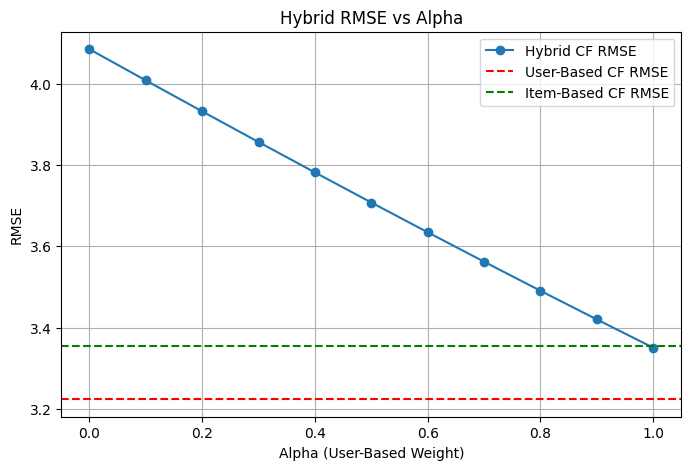

Alpha: 0.0 | RMSE: 4.0853 | NDCG: 0.9077 | Precision@10: 0.6885 | Recall@10: 0.8173 | F1: 0.7474
Alpha: 0.1 | RMSE: 4.0085 | NDCG: 0.9197 | Precision@10: 0.6885 | Recall@10: 0.8173 | F1: 0.7474
Alpha: 0.2 | RMSE: 3.9323 | NDCG: 0.9221 | Precision@10: 0.6885 | Recall@10: 0.8173 | F1: 0.7474
Alpha: 0.3 | RMSE: 3.8568 | NDCG: 0.9235 | Precision@10: 0.6885 | Recall@10: 0.8173 | F1: 0.7474
Alpha: 0.4 | RMSE: 3.7820 | NDCG: 0.9230 | Precision@10: 0.6885 | Recall@10: 0.8173 | F1: 0.7474
Alpha: 0.5 | RMSE: 3.7079 | NDCG: 0.9230 | Precision@10: 0.6885 | Recall@10: 0.8173 | F1: 0.7474
Alpha: 0.6 | RMSE: 3.6346 | NDCG: 0.9231 | Precision@10: 0.6885 | Recall@10: 0.8173 | F1: 0.7474
Alpha: 0.7 | RMSE: 3.5622 | NDCG: 0.9233 | Precision@10: 0.6885 | Recall@10: 0.8173 | F1: 0.7474
Alpha: 0.8 | RMSE: 3.4906 | NDCG: 0.9232 | Precision@10: 0.6885 | Recall@10: 0.8173 | F1: 0.7474
Alpha: 0.9 | RMSE: 3.4201 | NDCG: 0.9228 | Precision@10: 0.6885 | Recall@10: 0.8173 | F1: 0.7474
Alpha: 1.0 | RMSE: 3.3505 | ND

In [ ]:
alphas = [r['alpha'] for r in results]
rmses = [r['rmse'] for r in results]

plt.figure(figsize=(8, 5))
plt.plot(alphas, rmses, marker='o', label='Hybrid CF RMSE')

plt.axhline(y=rmse_user, color='r', linestyle='--', label='User-Based CF RMSE')
plt.axhline(y=rmse_item, color='g', linestyle='--', label='Item-Based CF RMSE')

plt.title('Hybrid RMSE vs Alpha')
plt.xlabel('Alpha (User-Based Weight)')
plt.ylabel('RMSE')
plt.grid(True)
plt.legend()
plt.show()

for r in results:
    print(f"Alpha: {r['alpha']:.1f} | RMSE: {r['rmse']:.4f} | NDCG: {r['ndcg']:.4f} | Precision@10: {r['precision@10']:.4f} | Recall@10: {r['recall@10']:.4f} | F1: {r['f1']:.4f}")


From the results, it appears that the user-based collaborative filtering method consistently outperforms the item-based CF across multiple evaluation metrics, such as RMSE, NDCG, Precision@10, and Recall@10. As the weight for user-based CF (alpha) increases in the hybrid model, we observe a steady improvement in ranking quality and accuracy. This suggests that user-based CF, which focuses on the similarities between users, is more effective at predicting ratings for unseen items in this particular dataset. On the other hand, the item-based CF method, which recommends items based on item similarity, shows less improvement and consistently results in higher RMSE and lower ranking metrics.

Given this trend, it seems that the hybrid model may not provide substantial additional benefit over the user-based CF alone, as user-based CF is already performing quite well. The hybrid approach might only be useful if the item-based CF could contribute significantly in scenarios where the user-based model struggles, such as in cases of sparsity or specific user-item interactions. However, in this case, the user-based CF appears to be the dominant model, making the hybrid approach less impactful.

